# H&E usage
The purpose of this notebook is to showcase how to perform basic analyses of H&E data and eventually combine it other modalities (transcriptomics or multiplex imaging).

You will need the `wsi` extra of sopa for this tutorial, i.e. `pip install sopa[wsi]`

In [1]:
import sopa
import spatialdata_plot

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


For this tutorial, we will use [this Xenium pancreatic cancer dataset](https://www.10xgenomics.com/datasets/pancreatic-cancer-with-xenium-human-multi-tissue-and-cancer-panel-1-standard). In particular, it has H&E attached to the spatial transcriptomics. You can also use the H&E alone by using the `sopa.io.wsi` reader.

To keep it simple, we will assume the Sopa pipeline has already been run, and for the sake of this tutorial we will directly use the Xenium default segmentation (`cells_boundaries=True`). If you use your own data after running Sopa, simply read your data with the `spatialdata.read_zarr` function.

In [2]:
# here, we will directly open the processed Xenium directory
sdata = sopa.io.xenium("data/xenium/Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs", cells_boundaries=True)

INFO     reading data/xenium/Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs/cell_feature_matrix.h5                    
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/spatialdata.py:160: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


When using Xenium data, your H&E image is already aligned. If it's not the case, or if you have another technology, then you can align the H&E image as in [this tutorial](../align/).

Here, we see that the H&E image is called `"he_image"`:

In [3]:
sdata

SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 71883, 20562), (3, 35941, 10281), (3, 17970, 5140), (3, 8985, 2570), (3, 4492, 1285)
│     ├── 'morphology_focus': DataTree[cyx] (1, 13752, 48274), (1, 6876, 24137), (1, 3438, 12068), (1, 1719, 6034), (1, 859, 3017)
│     └── 'morphology_mip': DataTree[cyx] (1, 13752, 48274), (1, 6876, 24137), (1, 3438, 12068), (1, 1719, 6034), (1, 859, 3017)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     └── 'cell_boundaries': GeoDataFrame shape: (190965, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (190965, 474)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), morphology_focus (Images), morphology_mip (Images), transcripts (Points), cell_boundaries (Shapes)

For efficiency in the tutorial, we will write the data on-disk (`.zarr` directory):

In [4]:
sdata.write("Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr")

INFO     The Zarr backing store has been changed from None the new file path:                                      
         Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr                                                          


In [1]:
import spatialdata
import sopa
import spatialdata_plot

sdata = spatialdata.read_zarr("Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr")
sopa.settings.auto_save_on_disk = False

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Tissue segmentation

Optionally, we can run tissue segmentation. This will create new polygons saved inside `sdata['region_of_interest']`.

> NB: by default, Sopa knows it should use `"he_image"` for tissue segmentation. Depending on your data, you might need to provide the `image_key` argument.

In [2]:
sopa.segmentation.tissue(sdata)

[INFO] (sopa.segmentation._tissue) Using image_key='he_image' and mode='saturation' as default


The tissue segmentation can be shown as below: 

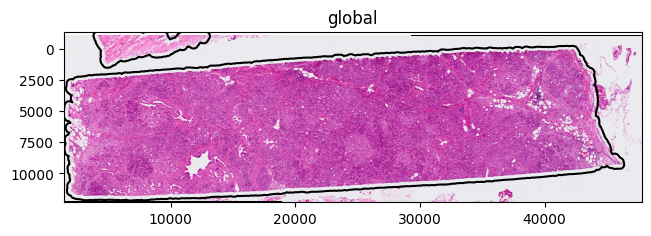

In [3]:
sdata\
    .pl.render_images("he_image", scale="scale3")\
    .pl.render_shapes("region_of_interest", outline_alpha=1, fill_alpha=0)\
    .pl.show("global")

## Patches embeddings and clusters

It is common to embed H&E patches using a computer vision model. Here, we use a ResNet model to embedding patches. On the following example, we compute embeddings for patches of width `250` pixels at the level 1 (i.e., the first sub-resolution image).

You can adjust the level to get different resolutions. For instance, `level=0, patch_width=100` would produce a resolution of about one cell per patch.

In [4]:
embedding = sopa.patches.compute_embeddings(sdata, "Resnet50Features", patch_width=256, level=3)

[INFO] (sopa.patches.infer) Processing 317 patches extracted from level 3
100%|██████████| 10/10 [00:35<00:00,  3.51s/it]
[INFO] (sopa.patches._patches) 317 patches were added to sdata['inference_patches']


Now, we have a key `'sopa_Resnet50Features'` containing the embeddings (as an image), and `'inference_patches'` containing the patches (as geometries).

In [5]:
sdata

SpatialData object, with associated Zarr store: /Users/quentinblampey/dev/sopa/docs/tutorials/Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 71883, 20562), (3, 35941, 10281), (3, 17970, 5140), (3, 8985, 2570), (3, 4492, 1285)
│     ├── 'morphology_focus': DataTree[cyx] (1, 13752, 48274), (1, 6876, 24137), (1, 3438, 12068), (1, 1719, 6034), (1, 859, 3017)
│     ├── 'morphology_mip': DataTree[cyx] (1, 13752, 48274), (1, 6876, 24137), (1, 3438, 12068), (1, 1719, 6034), (1, 859, 3017)
│     └── 'sopa_Resnet50Features': DataArray[cyx] (1024, 36, 11)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (190965, 1) (2D shapes)
│     ├── 'inference_patches': GeoDataFrame shape: (317, 3) (2D shapes)
│     └── 'region_of_interest': GeoDataFrame shape: (2, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (190965, 474)
with coordinate systems:
    ▸ 

Then, clustering can be run on the patches embeddings. This will add a `"cluster"` column to the a `GeoDataFrame` under `sdata["inference_patches"]` (defined in the previous line).

In [12]:
sopa.patches.cluster_embeddings(sdata, 'sopa_Resnet50Features')

,geometry,bboxes,ilocs,cluster
0,"POLYGON ((256.000 256.000, 256.000 59.646, 250...","[0, 0, 256, 256]","[0, 0]",3
1,"POLYGON ((256.000 256.000, 512.000 256.000, 51...","[256, 0, 512, 256]","[1, 0]",3
2,"POLYGON ((512.000 256.000, 768.000 256.000, 76...","[512, 0, 768, 256]","[2, 0]",3
3,"POLYGON ((768.000 256.000, 1024.000 256.000, 1...","[768, 0, 1024, 256]","[3, 0]",3
4,"POLYGON ((1024.000 256.000, 1280.000 256.000, ...","[1024, 0, 1280, 256]","[4, 0]",3
...,...,...,...,...
312,"POLYGON ((2048.000 8192.000, 1792.000 8192.000...","[1792, 8192, 2048, 8448]","[7, 32]",1
313,"POLYGON ((2048.000 8192.000, 2048.000 8244.426...","[2048, 8192, 2304, 8448]","[8, 32]",1
314,"POLYGON ((768.000 8448.000, 561.854 8448.000, ...","[512, 8448, 768, 8704]","[2, 33]",1
315,"POLYGON ((768.000 8448.000, 768.000 8522.141, ...","[768, 8448, 1024, 8704]","[3, 33]",1


The patches clusters can be shown with `spatialdata_plot`:

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


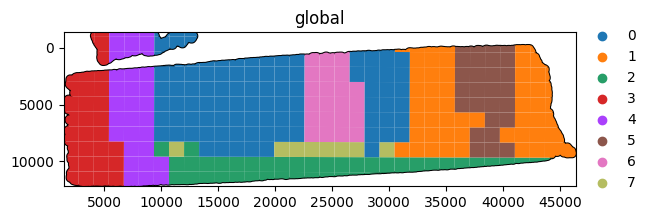

In [7]:
sdata\
    .pl.render_shapes("region_of_interest", outline_alpha=1, fill_alpha=0)\
    .pl.render_shapes("inference_patches", color="cluster")\
    .pl.show("global")

## Spatial join

You may be interested in joining the H&E patches and the cells. This way, you could know inside witch patch-cluster belongs each cell. This can be done with `sopa.spatial.sjoin`.

In [8]:
res_gdf = sopa.spatial.sjoin(sdata, "cell_boundaries", "inference_patches", target_coordinate_system="global")

The resulting `GeoDataFrame` may have more columns than cells, because one cell may be inside multiple patches. We will keep only the first patch, and then save the resulting `"cluster"` column into the `sdata.tables["table"]`.

In [9]:
sdata.tables["table"].obs["cluster"] = res_gdf[~res_gdf.index.duplicated()]["cluster"].values

Here, for simplicity, we use `scanpy` to plot the cells (as dots). But we could also use `spatialdata_plot`.

We can see the cells segmented by the Xenium, colored by the H&E patch in which they belong.

In [10]:
import scanpy as sc

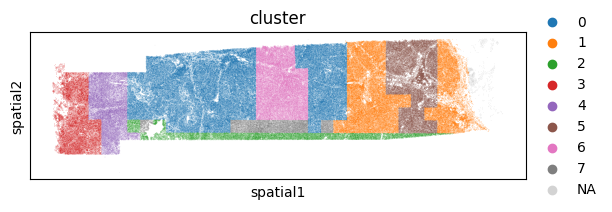

In [11]:
sc.pl.spatial(sdata["table"], color="cluster", spot_size=10)

In [25]:
sdata["table"].obs

,cell_id,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,region,cluster
0,aaaanbjb-1,143,0,0,0,0,143,172.225944,8.037813,cell_labels,1
1,aaabbnlb-1,112,0,0,0,0,112,334.517512,17.294844,cell_labels,1
2,aaabdean-1,81,0,0,0,0,81,180.263757,20.681563,cell_labels,1
3,aaabkppc-1,30,0,0,0,0,30,43.891877,6.637969,cell_labels,1
4,aaablfle-1,92,0,0,0,0,92,140.255318,27.093751,cell_labels,1
...,...,...,...,...,...,...,...,...,...,...,...
190960,oipjjmli-1,133,0,0,0,0,133,111.219848,24.429532,cell_labels,1
190961,oipkfocl-1,69,0,0,0,0,69,111.039223,16.888438,cell_labels,2
190962,oipkjaho-1,124,0,0,0,0,124,187.579069,23.120001,cell_labels,2
190963,oipkmkcd-1,242,0,0,0,0,242,236.167196,22.262032,cell_labels,1
